In this notebook, I will reproduce FIgure 1 a & e from this paper: https://www.nature.com/articles/s41587-023-01716-9

# Load packages

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

# Loading multiple samples into Scanpy

Data: 
Replicate 1: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM6005302
Replicate 2: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM6005304


In [3]:
adata_rep1 = sc.read_10x_h5('/Users/sangeevanvellappan/Desktop/scRNA/GSM6005302_BM_CD34_Rep1_filtered_feature_bc_matrix.h5')

/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata_rep1

AnnData object with n_obs × n_vars = 6973 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [6]:
adata_rep1.var_names_make_unique()

In [7]:
adata_rep1

AnnData object with n_obs × n_vars = 6973 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [8]:
adata_rep2 = sc.read_10x_h5('/Users/sangeevanvellappan/Desktop/scRNA/GSM6005304_BM_CD34_Rep2_filtered_feature_bc_matrix.h5')

/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
adata_rep2

AnnData object with n_obs × n_vars = 6797 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [10]:
adata_rep2.var_names_make_unique()

In [11]:
adata_rep2

AnnData object with n_obs × n_vars = 6797 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [12]:
import anndata
#combine/concatenate the replicates/batches
adata = anndata.concat([adata_rep1, adata_rep2], 
                       axis = 0,                        
                       join='inner', 
                       label='batch_id', 
                       index_unique='-', 
                       fill_value=0)

In [13]:
adata

AnnData object with n_obs × n_vars = 13770 × 36601
    obs: 'batch_id'

In [14]:
adata.obs['batch_id']

AAACAGCCACCTGTAA-1-0    0
AAACAGCCACTCGCTC-1-0    0
AAACAGCCACTGACCG-1-0    0
AAACAGCCATAATCAC-1-0    0
AAACATGCAAATTCGT-1-0    0
                       ..
TTTGTGTTCGTCAAGT-1-1    1
TTTGTGTTCTAACTGA-1-1    1
TTTGTGTTCTCAATTC-1-1    1
TTTGTTGGTTCGCTCA-1-1    1
TTTGTTGGTTTATTCG-1-1    1
Name: batch_id, Length: 13770, dtype: category
Categories (2, object): ['0', '1']

In [15]:
adata.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
# check for NaN:
np.sum(np.isnan(adata.X.toarray()))

0

## Basic QC

In [17]:
sc.pp.calculate_qc_metrics(adata, inplace = True)

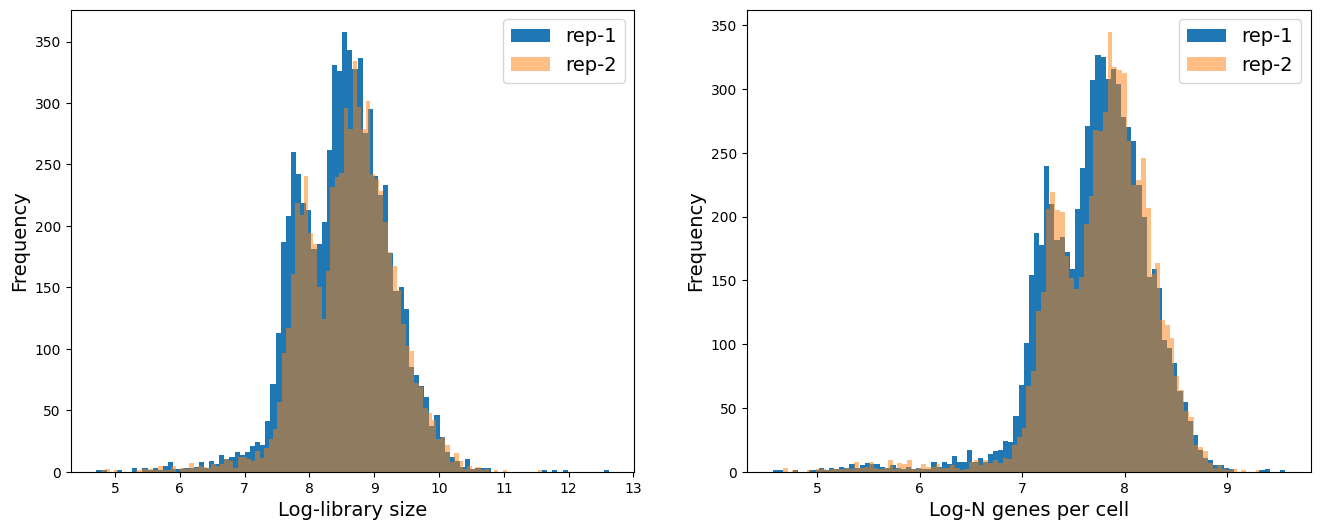

In [19]:
# Distribution of library size (total counts); number of genes per cell. replicate 1 and replicate 2 mostly look similar. will skip batch effect correction
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
ax.hist(adata.obs['log1p_total_counts'][adata.obs['batch_id'] == '0'], 100, label = 'rep-1')
ax.hist(adata.obs['log1p_total_counts'][adata.obs['batch_id'] == '1'], 100, label = 'rep-2', alpha = 0.5)
ax.set_xlabel('Log-library size', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.legend(fontsize = 14)

ax = fig.add_subplot(1, 2, 2)
ax.hist(adata.obs['log1p_n_genes_by_counts'][adata.obs['batch_id'] == '0'], 100, label = 'rep-1')
ax.hist(adata.obs['log1p_n_genes_by_counts'][adata.obs['batch_id'] == '1'], 100, label = 'rep-2', alpha = 0.5)
ax.set_xlabel('Log-N genes per cell', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.legend(fontsize = 14)

I think if we have more than 2 batches, we can run a for loop to visualize the distribution of each batch compared to the whole data

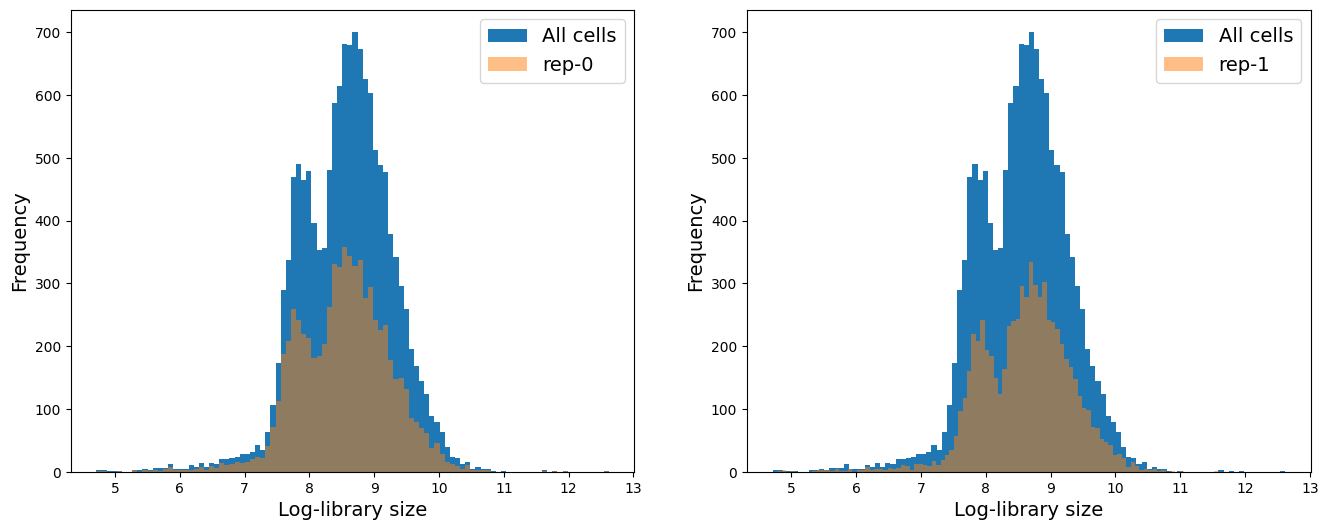

In [20]:
# Distribution of library size (total counts)
fig = plt.figure(figsize = (8*2, 6*1))
for j, item in enumerate(np.unique(adata.obs['batch_id'])):
    ax = fig.add_subplot(1, 2, j+1)
    ax.hist(adata.obs['log1p_total_counts'], 100, label = 'All cells')
    ax.hist(adata.obs['log1p_total_counts'][adata.obs['batch_id'] == item], 100, label = 'rep-' + item, 
            alpha = 0.5)
    ax.set_xlabel('Log-library size', fontsize = 14)
    ax.set_ylabel('Frequency', fontsize = 14)
    ax.legend(fontsize = 14)

(0.0, 500.0)

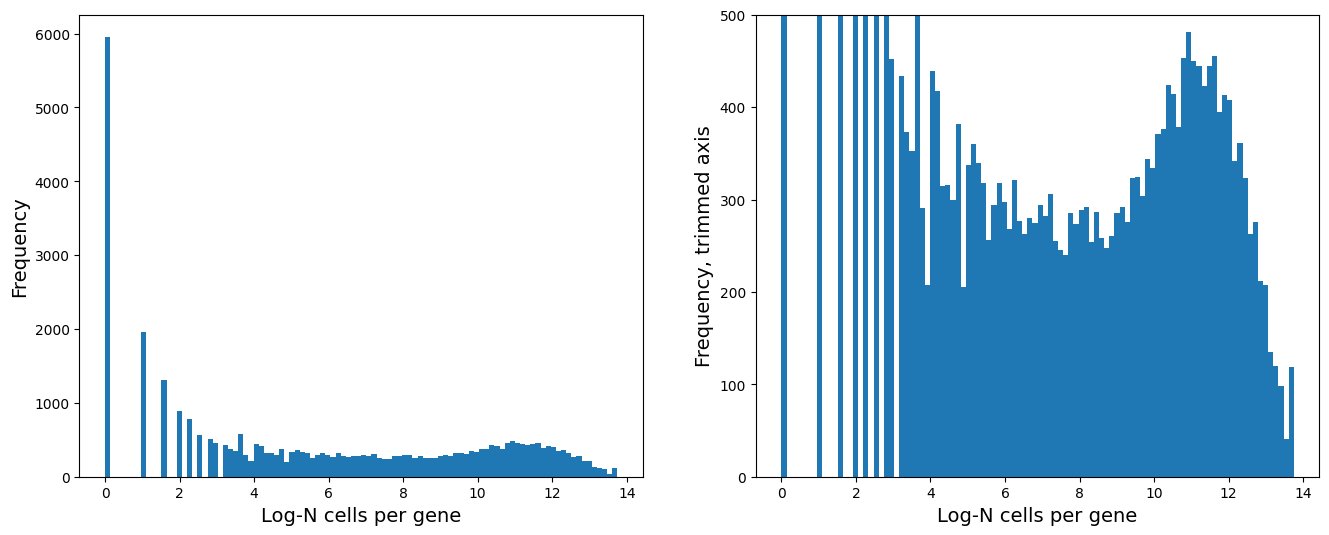

In [21]:
# Distribution of number of genes a cell is expressed in
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
ax.hist(np.log2(adata.var['n_cells_by_counts'] + 1), 100)
ax.set_xlabel('Log-N cells per gene', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1, 2, 2)
ax.hist(np.log2(adata.var['n_cells_by_counts'] + 1), 100)
ax.set_xlabel('Log-N cells per gene', fontsize = 14)
ax.set_ylabel('Frequency, trimmed axis', fontsize = 14)
ax.set_ylim([0, 500])

In [22]:
#In the paper-cells with percentage mitochondrial content greater than 25% were discarded from further analysis. Similarly, genes expressed in less than 50 cells were also discarded. 

#Remove genes expressed in less than 50 cells: 
sc.pp.filter_genes(adata, min_cells=50)

In [23]:
adata

AnnData object with n_obs × n_vars = 13770 × 17909
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

## % mito and ribo

In [24]:
# Identify MT-genes
mito_genes = adata.var_names[adata.var_names.str.startswith('MT-')]

In [25]:
# now we need the row sum of the subsetted data to compute % mito content
row_sum_adata_mito = np.sum(adata[:, mito_genes].X.toarray(), axis = 1)

In [26]:
# compute the % of mito content by dividing the above result by library size
adata.obs['pct_counts_mt'] = row_sum_adata_mito/adata.obs['total_counts'] * 100

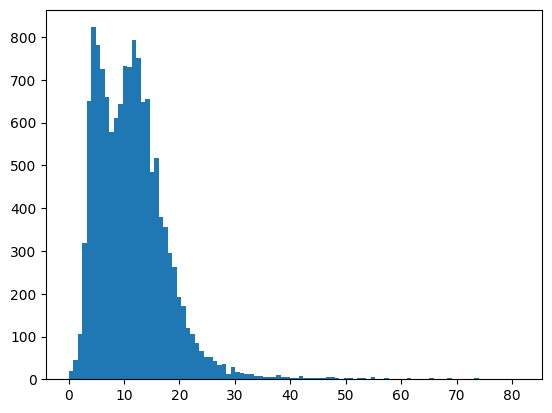

In [27]:
plt.hist(adata.obs['pct_counts_mt'], 100);

In [28]:
# Identify ribo-genes
ribo_genes = adata.var_names[adata.var_names.str.startswith(('RPS', 'RPL'))]

In [29]:
# now we need the row sum of the subsetted data to compute % mito content
row_sum_adata_ribo = np.sum(adata[:, ribo_genes].X.toarray(), axis = 1)

In [30]:
# compute the % of ribo content by dividing the above result by library size
adata.obs['pct_counts_ribo'] = row_sum_adata_ribo/adata.obs['total_counts'] * 100

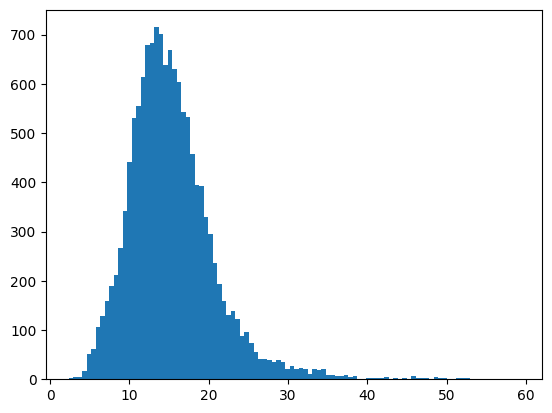

In [31]:
plt.hist(adata.obs['pct_counts_ribo'], 100);

For the sake of exposition, the following code removes cells with MT-content greater than 25%.

In [32]:
adata_clean = adata[adata.obs['pct_counts_mt'] < 25, :]

In [33]:
adata_clean

View of AnnData object with n_obs × n_vars = 13350 × 17909
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

Text(0, 0.5, 'Frequency')

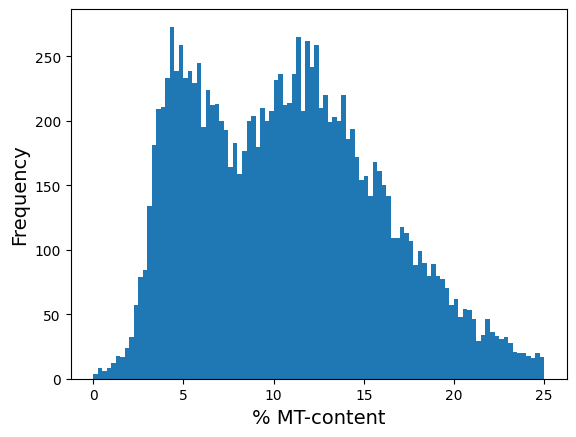

In [35]:
# just double check: there must be no cell with MT > 25
plt.hist(adata_clean.obs['pct_counts_mt'], 100);
plt.xlabel('% MT-content', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

In [36]:
adata_clean2 = adata_clean[adata_clean.obs['pct_counts_ribo'] < 25, :]

In [37]:
adata_clean2 = adata_clean[:, ~adata_clean.var_names.str.startswith(('RPS', 'RPL'))]

In [38]:
adata_clean2

View of AnnData object with n_obs × n_vars = 13350 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [39]:
adata_clean2.write_h5ad('/Users/sangeevanvellappan/Desktop/scRNA/processed_adata.h5ad')